### Resources:
* [D-separation steps](http://web.mit.edu/jmn/www/6.034/d-separation.pdf)
* [bnlearn datasets](https://www.bnlearn.com/bnrepository/)
* [Daggity paper](https://academic.oup.com/ije/article/45/6/1887/2907796)
* [Milestone](https://gitlab.pnnl.gov/y0-scuc/y0-archive/-/milestones/4)
* [pgmpy](https://github.com/pgmpy/pgmpy/blob/dev/examples/Creating%20a%20Discrete%20Bayesian%20Network.ipynb)  -- get_independencies

### TODO:
* Break into module, write proper unit tests
* What about conditional independencies?  Currently only covers independencies.  
   * Can I just enumerate tripples and check 'A,B given=["C"]'?  
   * Would then check combinations-pairs + combinations-givens 
   * Up to how many givens do you check?

In [1]:
from y0.algorithm import falsification
from y0.graph import ADMG
import y0.examples

import networkx as nx
import pandas as pd

import seaborn as sns
from itertools import chain
from tqdm import tqdm
%matplotlib inline

%load_ext autoreload
%autoreload 2

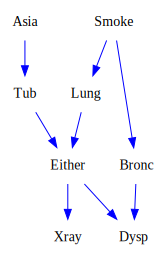

In [2]:
asia_G = y0.examples.asia_example.graph.to_admg()
asia_df = y0.examples.asia_example.data

asia_G.draw()

In [3]:
issues = falsification.falsifications(asia_G, asia_df, max_given=2, verbose=True)

d-separation check: 28it [00:00, 346.48it/s]
Checking conditionals: 100%|██████████| 17/17 [00:00<00:00, 202.51it/s]


In [4]:
issues.evidence

,left,right,given,chi^2,p,dof,Holm–Bonferroni level,flagged
15,Asia,Xray,"(Either,)",4.268355,0.118342,2,0.016667,False
16,Bronc,Lung,"(Smoke,)",3.477138,0.175772,2,0.025000,False
5,Asia,Dysp,"(Tub,)",1.498154,0.472803,2,0.003846,False
10,Dysp,Xray,"(Either,)",0.656339,0.720241,2,0.006250,False
9,Smoke,Xray,"(Either,)",0.487209,0.783798,2,0.005556,False
2,Bronc,Xray,"(Either,)",0.206653,0.901833,2,0.003125,False
8,Asia,Bronc,(),2.495844,0.114147,1,0.005000,False
0,Bronc,Tub,(),2.364399,0.124132,1,0.002778,False
3,Asia,Smoke,(),1.841060,0.174827,1,0.003333,False
4,Bronc,Either,"(Lung,)",1.206968,0.271933,1,0.003571,False


In [5]:
# Should be issues (Lung, Either) AT LEAST.
#.  Seeing issues (Lung, Xray) as well.  Is that all? 
# TODO: Check d-separations by hand...
import copy
asia_G2 = copy.deepcopy(asia_G)
asia_G2.delete_diedge("Lung", "Either")
issues = falsification.falsifications(asia_G2, asia_df)
issues

11     (Dysp, Lung, (Bronc,))
12    (Dysp, Smoke, (Bronc,))
10           (Lung, Xray, ())
17         (Either, Lung, ())
18        (Either, Smoke, ())
0           (Smoke, Xray, ())
20        (Bronc, Either, ())
15          (Bronc, Xray, ())
dtype: object+evidence

In [6]:
issues.evidence

,left,right,given,chi^2,p,dof,Holm–Bonferroni level,flagged
11,Dysp,Lung,"(Bronc,)",296.251065,0.000000e+00,2,0.004545,True
12,Dysp,Smoke,"(Bronc,)",21.128858,2.581824e-05,2,0.005000,True
10,Lung,Xray,(),2094.106838,0.000000e+00,1,0.004167,True
17,Either,Lung,(),3099.534805,0.000000e+00,1,0.010000,True
18,Either,Smoke,(),196.335994,1.316547e-44,1,0.012500,True
0,Smoke,Xray,(),127.464729,1.469901e-29,1,0.002273,True
20,Bronc,Either,(),22.547558,2.050050e-06,1,0.025000,True
15,Bronc,Xray,(),14.983980,1.084278e-04,1,0.007143,True
4,Asia,Xray,"(Either,)",4.268355,1.183419e-01,2,0.002778,False
5,Bronc,Lung,"(Smoke,)",3.477138,1.757718e-01,2,0.002941,False


In [7]:
sorted((1,2))

[1, 2]